# Using PPC for model evaluation

## What is PPC?

Posterior Predictive checks (PPC) are a way to validate the goodness of fit of your generative models by computing metrics on reconstructed counts and on the raw counts and comparing the results. Samples are taken from the posterior predictive distribution: $p(\hat{x} \mid x)$.

You can build a better intuition for it by reading more [here](http://edwardlib.org/tutorials/criticism) and [here](https://stats.stackexchange.com/questions/115157/what-are-posterior-predictive-checks-and-what-makes-them-useful).

## Imports

In [1]:
import scvi
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scvi_criticism import run_ppc, PPC, PPCPlot

Global seed set to 0
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-criticism-2/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-criticism-2/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Get the data and model

Here we use the data and pre-trained model obtained from running [this](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html) scvi-tools tutorial.

The dataset used is a subset of the heart cell atlas dataset:  
Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

If you have not yet pre-trained the model uncomment and run the below to pre-train the model and save it locally:

In [11]:
# adata = scvi.data.heart_cell_atlas_subsampled()
# sc.pp.filter_genes(adata, min_counts=3)
# adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.raw = adata
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=1200,
#     subset=True,
#     layer="counts",
#     flavor="seurat_v3",
#     batch_key="cell_source"
# )
# scvi.model.SCVI.setup_anndata(
#     adata,
#     layer="counts",
#     categorical_covariate_keys=["cell_source", "donor"],
#     continuous_covariate_keys=["percent_mito", "percent_ribo"]
# )
# model = scvi.model.SCVI(adata)
# model.train()
# model.save("local/hca/")

Run this to load the model:

In [2]:
model_path = "local/hca"
model = scvi.model.SCVI.load(model_path)

INFO     File local/hca/model.pt already downloaded                                                                


In [3]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained

In [4]:
model.adata

AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'log1p'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'

## Overview of scvi-criticism

There are two classes that you can use with `scvi-criticism`. One is the `PPC` class and the other is the `PPCPlot` class.

### `scvi-criticism.PPC`

The `PPC` class can be used to compute posterior predictive samples and compute various metrics on them.  
The figure below gives an overview of the input/outputs of this class.  

<center><img src="https://raw.githubusercontent.com/yoseflab/scvi-criticism/main/docs/notebooks/figures/ppc.png?raw=true" /></center>

Currently, three metrics are implemented:
- [Coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) &mdash; aka CV. This is the mean divided by the variance and can be computed cell-wise or gene-wise. We support both.
- [Mann–Whitney U](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) &mdash; aka MWU.
- [Differential expression](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Finding-marker-genes).

We will see each of these in more detail below where we compute and plot the output of each of them.

The `scvi-criticism` package also provides a convenience function called `run_ppc` that you can call with your favorite metric that you want to compute for a given model. It will take care of much of the boilerplate and call the right PPC methods so you don't have to.  

```python
def run_ppc(
    adata: AnnData,
    model,
    metric: str,
    n_samples: int,
    layer: Optional[str] = None,
    custom_indices: Optional[Union[int, Sequence[int]]] = None,
    **metric_specific_kwargs,
)
```

### `scvi-criticism.PPCPlot`

As its name indicates, the `scvi-criticism.PPCPlot` class can be used to draw various plots displaying metrics computed by the `PPC` class.  
The `PPCPlot` class takes a single required argument which is the instance of PPC that holds your computed metrics. 

We'll see concrete examples of how to use PPCPlot below where we compute different metrics on our data.

## PPC + coefficient of variation

First, let's run PPC and use the coefficient of variation as metric.  

Below is the code to do so, with step by step explanations. We'll later see that we can skip most of this with a simple call to `run_ppc`.

```python
# pick the indices you want to use. here we use all observations
indices = np.arange(model.adata.n_obs)

# get the raw (counts) data from .X or a layer if applicable
raw_data = model.adata[indices].layers["counts"]

# create PPC instance
n_samples = 5
ppc = PPC(n_samples=n_samples, raw_counts=raw_data)

# define your models dictionary. here we use only one model
model_name = f"{model.__class__.__name__}"
models_dict = {model_name: model}

# compute posterior predictive samples for your models
ppc.store_posterior_predictive_samples(models_dict, indices=indices)

# calculate the CV metric
ppc.coefficient_of_variation(cell_wise=True)

Instead of the above, you can simply call `run_ppc` which will do exactly the same as above.

In [15]:
n_samples = 5
ppc = run_ppc(model.adata, model, "cv_cell", n_samples = n_samples, layer="counts")

In [16]:
ppc

--- Posterior Predictive Checks ---
n_samples = 5
raw_counts shape = (18641, 1200)
models: ['SCVI']
metrics: 
{
    "cv_cell": "Pandas DataFrame with shape=(18641, 2), columns=['SCVI', 'Raw']"
}

Let's see what the cv_cell metric contains:

In [8]:
ppc.metrics["cv_cell"]

,SCVI,Raw
0,6.510572,9.820683
1,7.702765,8.686443
2,5.373195,4.587027
3,6.202974,6.262758
4,4.776725,5.975578
...,...,...
18636,6.560287,8.613652
18637,6.063679,5.561197
18638,9.950002,10.452272
18639,6.241374,7.699229


This is a pandas DataFrame where each row is a cell. The "Raw" column contains the cell-wise coefficient of variation computed on the raw data. The "SCVI" column contains the same computed on the posterior predictive samples (averaged over the N posterior predictive samples). If our model fits the data well, according to this metric, we'd ideally want these values to be "similar".  

Let's evaluate this similarity by:
- plotting a scatterplot that disaplys these values, and comparing it (visually) to the identity line
- computing the correlation of these vectors

This is where we can use the `PPCPlot` class. 

INFO     model=SCVI | metric=cv_cell | n_cells=18641:                                                              
         Mean Absolute Error=0.87,                                                                                 
         Mean Squared Error=1.62                                                                                   
         Pearson correlation=0.80                                                                                  
         Spearman correlation=0.82                                                                                 
                                                                                                                   


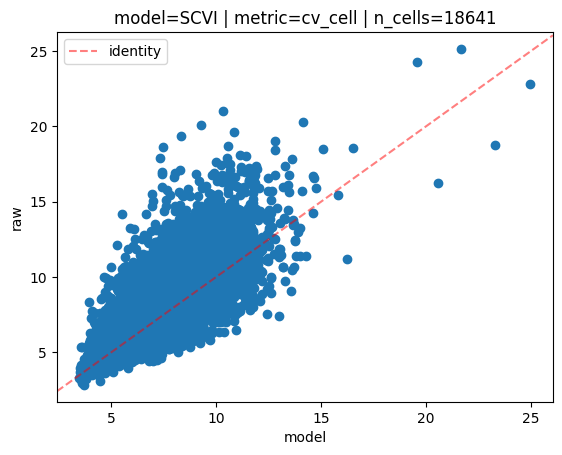

In [9]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True)

On the scatterplot above, each dot is a cell. The y axis represents the cell-wise coefficient of variation values computed for each cell on the raw data. The x axis represents the cell-wise coefficient of variation values computed for each cell on the posterior predictive samples (averaged over the N samples).  

We also compute a few different correlation metrics, namely mean absolute/squared errors, and pearson/spearman correlations.

Let's do the same but gene-wise:

In [10]:
ppc = run_ppc(model.adata, model, "cv_gene", n_samples = n_samples, layer="counts")

In [11]:
ppc

--- Posterior Predictive Checks ---
n_samples = 5
raw_counts shape = (18641, 1200)
models: ['SCVI']
metrics: 
{
    "cv_gene": "Pandas DataFrame with shape=(1200, 2), columns=['SCVI', 'Raw']"
}

INFO     model=SCVI | metric=cv_gene | n_cells=18641:                                                              
         Mean Absolute Error=1.36,                                                                                 
         Mean Squared Error=14.29                                                                                  
         Pearson correlation=0.95                                                                                  
         Spearman correlation=0.99                                                                                 
                                                                                                                   


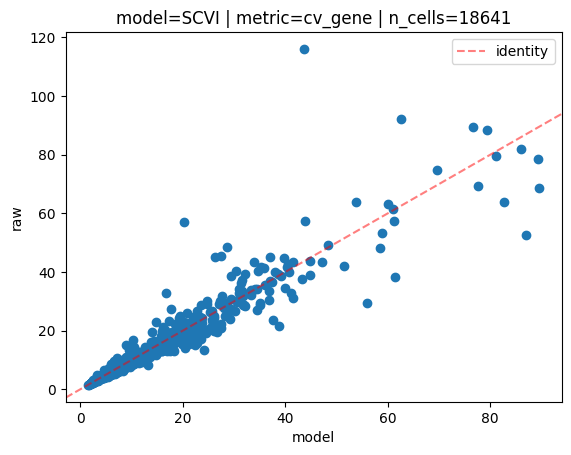

In [12]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=False)

This time each dot on the scatterplot is a gene. As expected, there is fewer of them in this case.

## PPC + DE

In this section, we evaluate goodness of fit of the model by running differential expression on the raw data, then on the reconstructed counts and comparing the DE results.   
Once again, we can use `run_ppc` to compute the metric for us in one call:

In [19]:
n_samples = 1
ppc = run_ppc(model.adata, model, "diff_exp", n_samples = n_samples, layer="counts", de_groupby="cell_type")

In [20]:
ppc

--- Posterior Predictive Checks ---
n_samples = 1
raw_counts shape = (18641, 1200)
models: ['SCVI']
metrics: 
{
    "diff_exp": {
        "adata_raw": "AnnData object with n_obs=18641, n_vars=1200",
        "var_names": {
            "Adipocytes": [
                "GPAM",
                "MGST1"
            ],
            "Atrial_Cardiomyocyte": [
                "MYL7",
                "RYR2"
            ],
            "Endothelial": [
                "VWF",
                "B2M"
            ],
            "Fibroblast": [
                "DCN",
                "NEGR1"
            ],
            "Lymphoid": [
                "PTPRC",
                "B2M"
            ],
            "Mesothelial": [
                "ITLN1",
                "PLA2G2A"
            ],
            "Myeloid": [
                "CD163",
                "CTSB"
            ],
            "Neuronal": [
                "NRXN1",
                "CDH19"
            ],
            "Pericytes": [
                "RGS

There is quite a lot of information in the metrics this time, so let's take a closer look:

- **`ppc.metrics["diff_exp"].adata_raw`**  is simply the raw counts data.
- **`ppc.metrics["diff_exp"].var_names`** is a dictionary where keys are DE groups (for example cell types), and values are arrays containing the N top differentially expressed genes in that group. The N can be specified via `n_top_genes` in the call to `run_ppc` and defaults to 2.
- **`ppc.metrics["diff_exp"].lfc_df_raw`** is a pandas DataFrame where rows are groups, and columns are the N top genes for all groups, i.e., `n_cols = n_top_genes_per_group * n_groups`.  

    Each DataFrame cell (group,gene) contains: `log2(mean_gene_expression_in_group / mean_gene_expression_not_in_group)` for that gene, where:
    - `mean_gene_expression_in_group` is the average gene expression of that gene for all cells in that group
    - `mean_gene_expression_not_in_group` is the average gene expression of that gene for all other cells (not in that group)  

    This is also called "1 vs all" logfoldchange (LFC).
- **`ppc.metrics["diff_exp"].fraction_df_raw`** is a pandas DataFrame where rows and columns are the same as `ppc.metrics["diff_exp"].lfc_df_raw`. Each DataFrame cell (group,gene) contains the fraction of cells in that group that express that gene.
- **`ppc.metrics["diff_exp"]["SCVI"]`** is a dictionary that contains the outputs of computing different metrics that are specific to the model called "SCVI".
    - **`ppc.metrics["diff_exp"]["SCVI"]["adata_approx"]`** is the reconstructed count data.
    - **`ppc.metrics["diff_exp"]["SCVI"]["lfc_adata_approx"]`** is the same as `lfc_df_raw` but for the estimated count data.
    - **`ppc.metrics["diff_exp"]["SCVI"]["lfc_mae"]`** is the row-wise mean absolute error between `lfc_df_raw` and `lfc_adata_approx`.
    - **`ppc.metrics["diff_exp"]["SCVI"]["lfc_mae_mean"]`** is the mean of `lfc_mae`.
    - **`ppc.metrics["diff_exp"]["SCVI"]["lfc_pearson"]`** is the row-wise pearson correlation between `lfc_df_raw` and `lfc_adata_approx`.
    - **`ppc.metrics["diff_exp"]["SCVI"]["lfc_pearson_mean"]`** is the mean of `lfc_pearson`.
    - **`ppc.metrics["diff_exp"]["SCVI"]["lfc_spearman"]`** is the row-wise spearman correlation between `lfc_df_raw` and `lfc_adata_approx`.
    - **`ppc.metrics["diff_exp"]["SCVI"]["lfc_spearman_mean"]`** is the the mean of `lfc_spearman`.
    - **`ppc.metrics["diff_exp"]["SCVI"]["fraction_df_approx"]`** is the same as `fraction_df_raw` but for the estimated count data.
    - **`ppc.metrics["diff_exp"]["SCVI"]["fraction_mae"]`** is the same as `lfc_mae` but for gene expression fractions instead of lfc.
    - **`ppc.metrics["diff_exp"]["SCVI"]["fraction_mae_mean"]`** is the same as `lfc_mae_mean` but for gene expression fractions.
    - **`ppc.metrics["diff_exp"]["SCVI"]["fraction_pearson"]`** is the same as `lfc_pearson` but for gene expression fractions.
    - **`ppc.metrics["diff_exp"]["SCVI"]["fraction_pearson_mean"]`** is the same as `lfc_pearson_mean` but for gene expression fractions.
    - **`ppc.metrics["diff_exp"]["SCVI"]["fraction_spearman"]`** is the same as `lfc_spearman` but for gene expression fractions.
    - **`ppc.metrics["diff_exp"]["SCVI"]["fraction_spearman_mean"]`** is the same as `lfc_spearman_mean` but for gene expression fractions.
    - **`ppc.metrics["diff_exp"]["SCVI"]["gene_comparisons"]`** is a pandas DataFrame where rows are groups. Each row reports a precision, recall and [F1 score](https://en.wikipedia.org/wiki/F-score) that represents the overlap between the top N differentially expressed genes in that group on the raw data and the top N differentially expressed genes in that group on the estimated count data. The N can be specified via `n_top_genes_overlap` in the call to `run_ppc` and defaults to: `min(adata_raw.n_vars, DEFAULT_DE_N_TOP_GENES_OVERLAP)`. 

        This is how this overlap is calculated: for each group, we consider the unordered set of top ranked genes between raw and approx DE results. To do that we "binarize" the gene selections: we create two binary vectors (one for raw, one for approx) where a 1 in the vector means gene was selected. We then compute the precision, recall and F1 score between these two vectors. Below is a depiction of those notions in this context:   
    
        <center><img src="https://raw.githubusercontent.com/yoseflab/scvi-criticism/main/docs/notebooks/figures/prf.png?raw=true" width="400" /></center>

That's a lot of text. Let's visualize some of these metrics.

First, let's look at the "1 vs all" LFC dotplot for the raw and approximated count data:

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-criticism-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


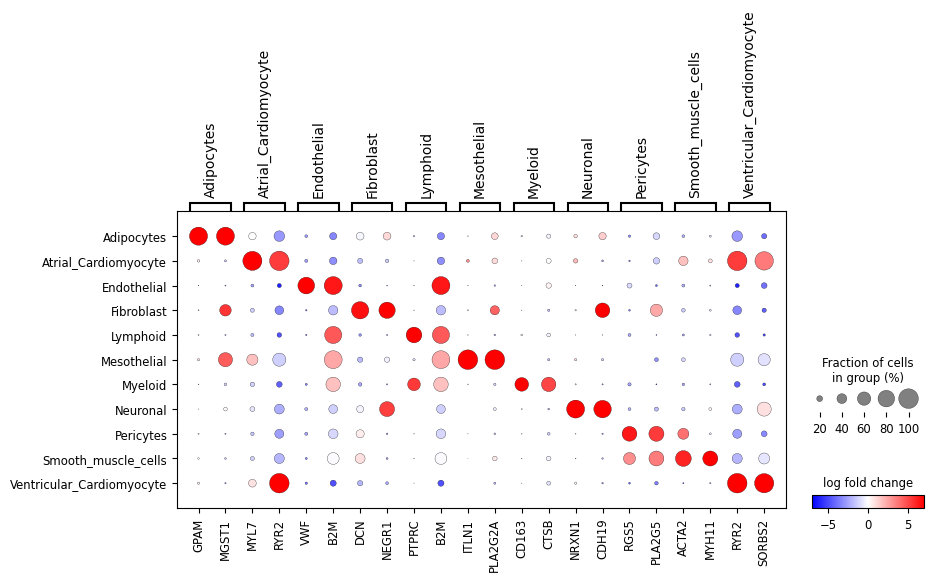

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-criticism-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


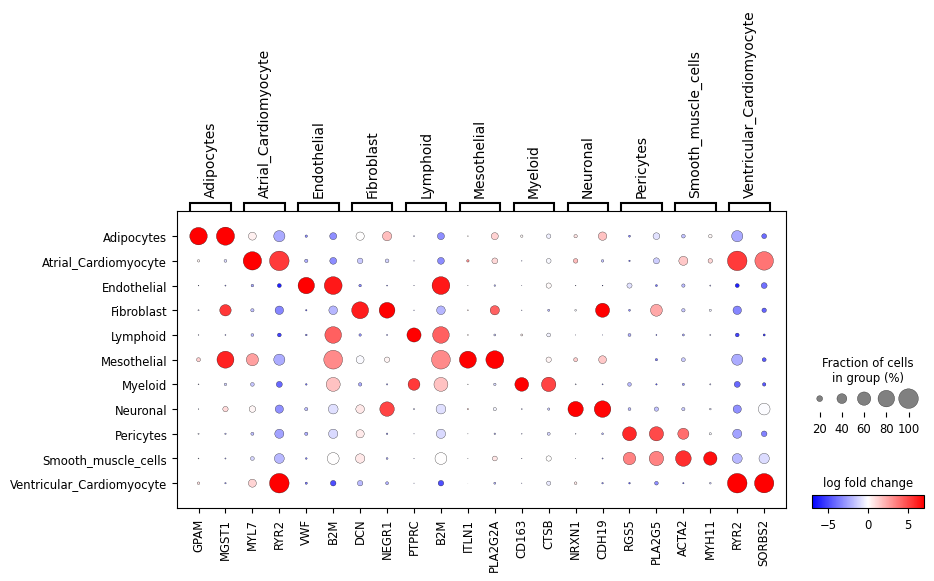

In [21]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp("SCVI")

We can also look at a subset of the genes:

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-criticism-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


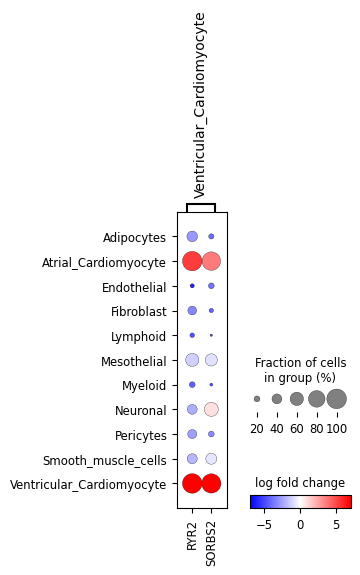

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-criticism-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


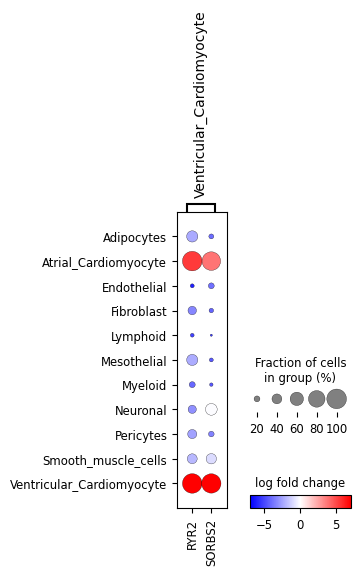

In [22]:
ppc_plt.plot_diff_exp("SCVI", var_names_subset=["Ventricular_Cardiomyocyte"])

These all look very similar but it's hard to evaluate that visually. Let's look at the mean absolute error (MAE), pearson and spearman correlations between the two:

INFO     LFC (1 vs all) gene expressions across groups:                                                            
         Mean Absolute Error=0.71,                                                                                 
         Pearson correlation=0.93                                                                                  
         Spearman correlation=0.94                                                                                 


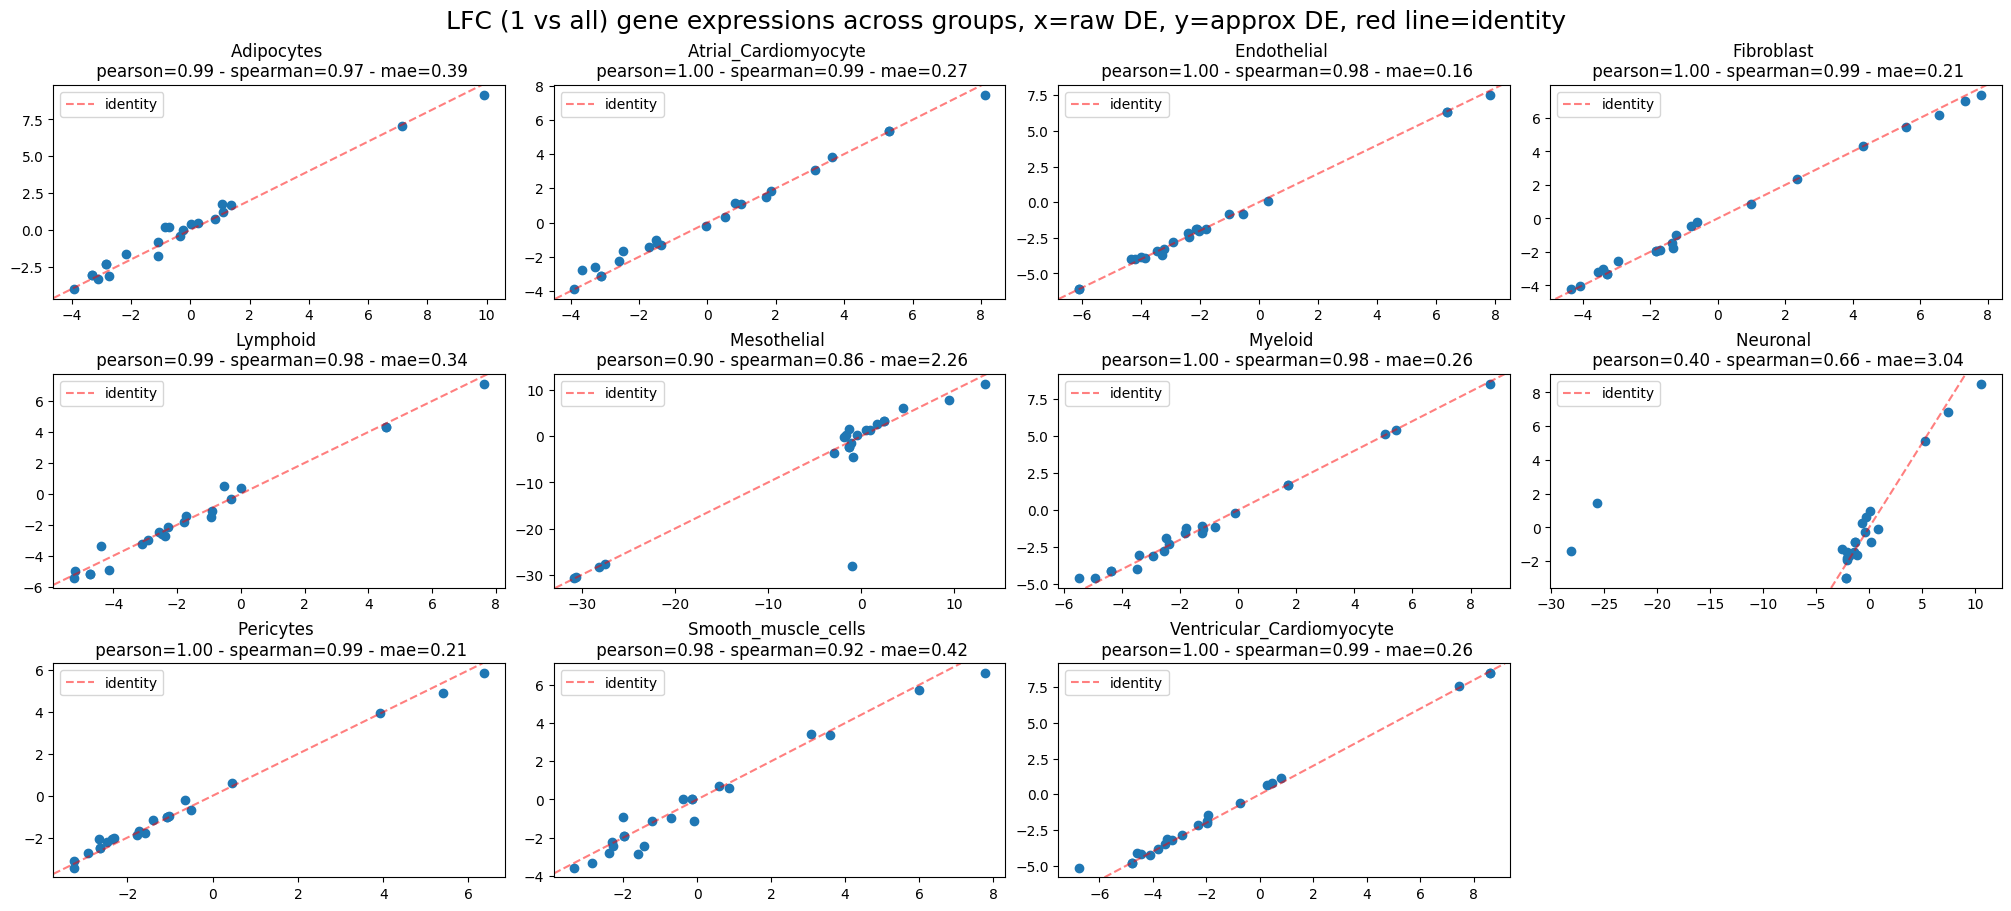

In [26]:
ppc_plt.plot_diff_exp("SCVI", plot_kind="lfc_comparisons")

INFO     fractions of genes expressed per group across groups:                                                     
         Mean Absolute Error=0.02,                                                                                 
         Pearson correlation=0.99                                                                                  
         Spearman correlation=0.98                                                                                 


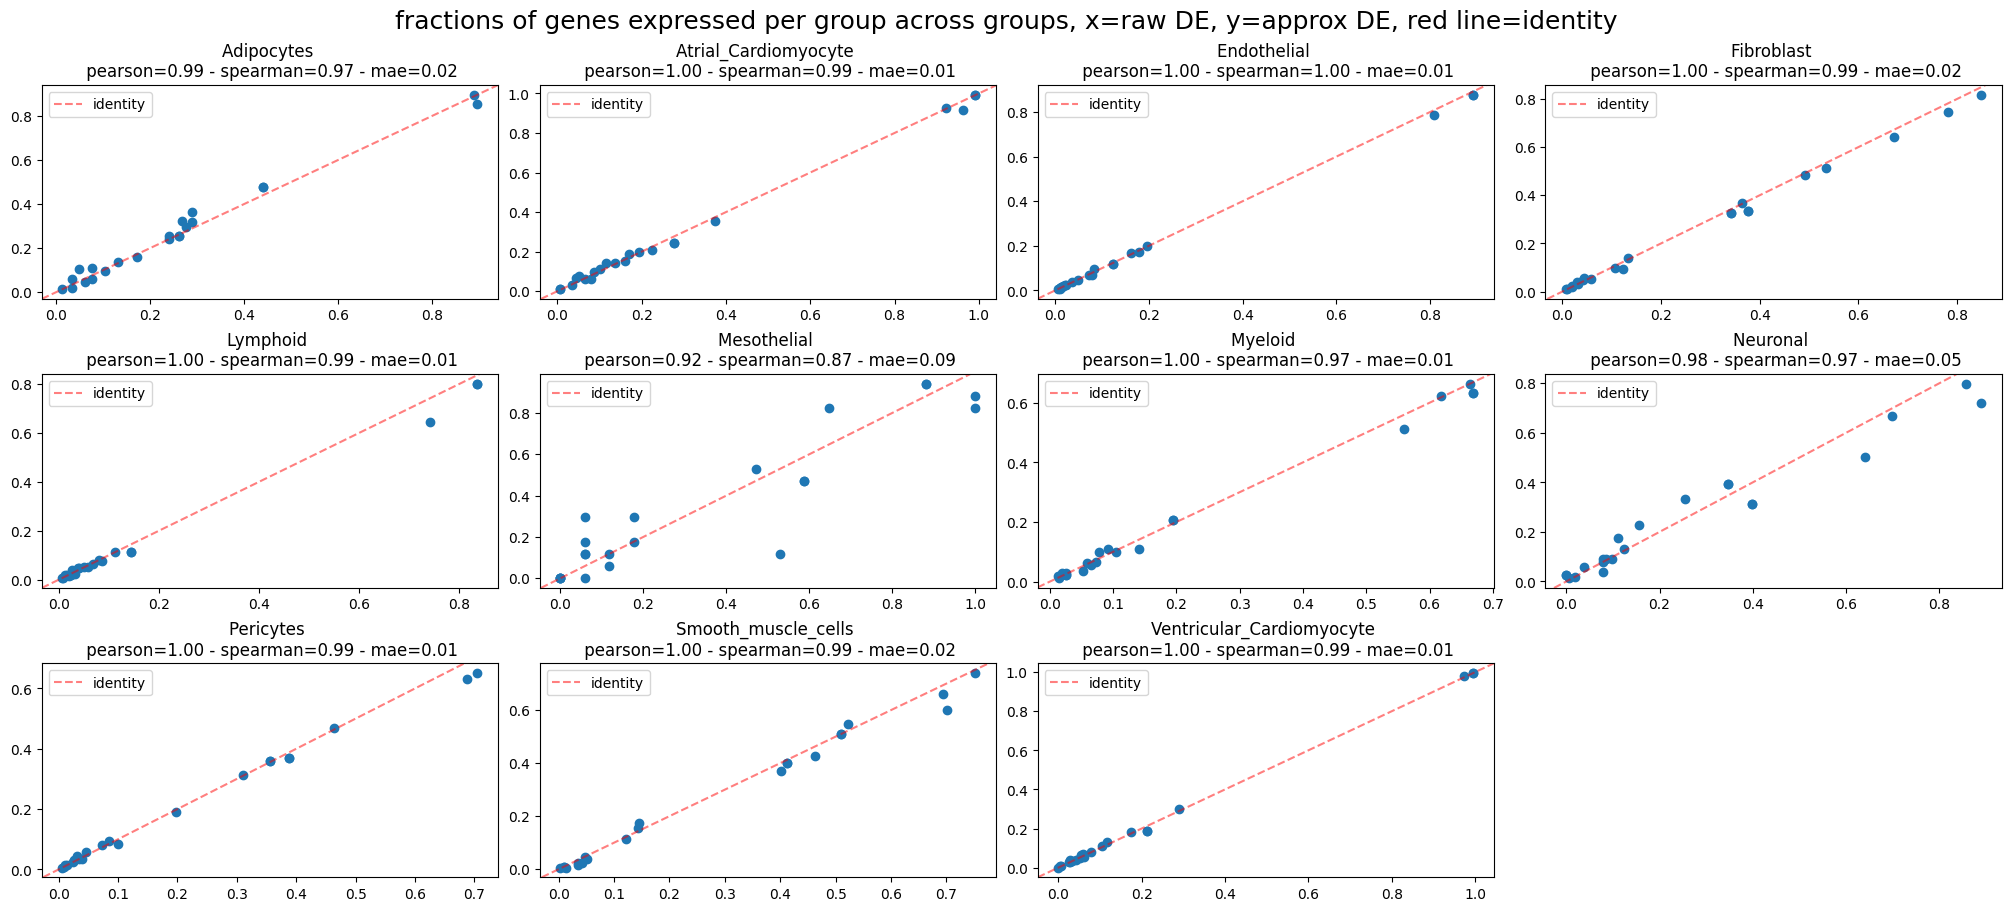

In [27]:
ppc_plt.plot_diff_exp("SCVI", plot_kind="fraction_comparisons")

That looks pretty good.  

Next, let's look at the F1 score for the top N genes that are differentially expressed in each group:

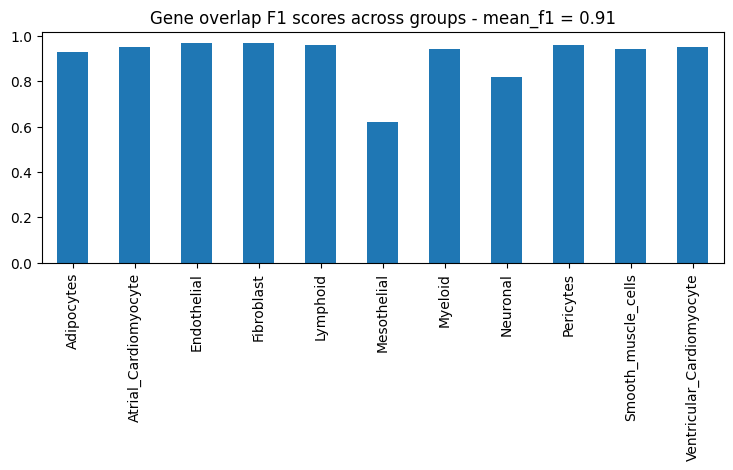

In [28]:
ppc_plt.plot_diff_exp("SCVI", plot_kind="gene_overlaps")

Last but not least, let's plot a summary. In the box plot below, dots are groups and the x axis represents the various metrics we computed and plotted separately earlier. The box plot shows the distribution of the metrics across groups.

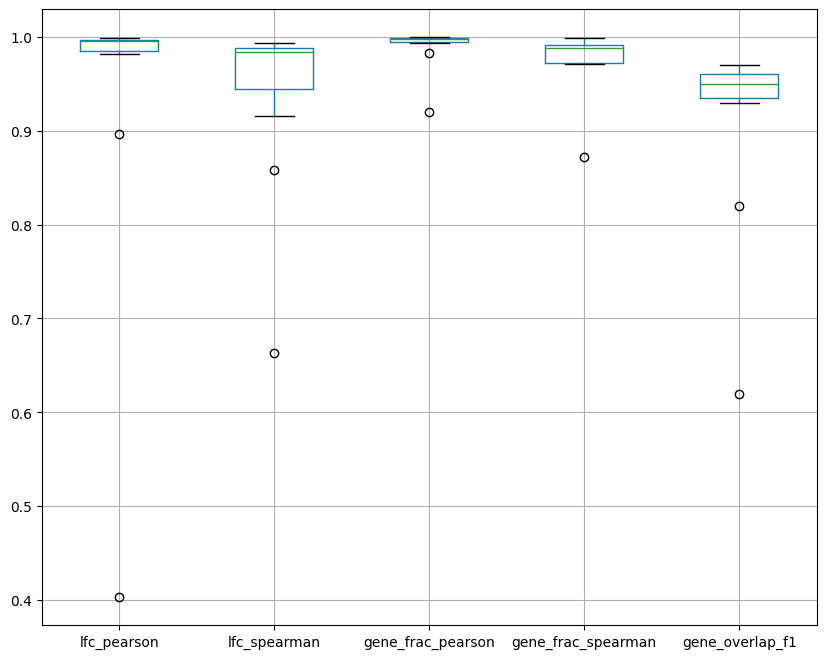

In [29]:
ppc_plt.plot_diff_exp("SCVI", plot_kind="summary")